In [92]:
# Roll Nos : 23B0977 (Keyaan Kartikeya Rajesh), 23B1052 (Ramachandran S), 23B1085 (Harith S)
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [93]:
def mase(actual, forecast, train_data):
    naive_forecast = train_data.shift(1).dropna()
    mae_naive = mean_absolute_error(train_data[1:], naive_forecast)
    return mean_absolute_error(actual, forecast) / mae_naive

In [94]:
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [95]:
def report_errors(test_data, forecast, train_data):
    mase_value = mase(test_data, forecast, train_data)
    mape_value = mape(test_data, forecast)
    return mase_value, mape_value

In [96]:
def calculate_parking_times(data):
    cleaned_data = data

    vehicle_entries = {}
    parking_durations = []

    cleaned_data = cleaned_data.sort_values('timestamp')

    for _, row in cleaned_data.iterrows():
        vehicle_id = row['vehicle_no']
        timestamp = row['timestamp']
        camera_id = row['camera_id']

        # if vehicle enters, keep track of the id
        if camera_id == 1:
            vehicle_entries[vehicle_id] = timestamp
        # if a vehicle exits check whether it has entered, and then
        elif camera_id == 2 and vehicle_id in vehicle_entries:
            entry_time = vehicle_entries[vehicle_id]
            # time spent
            duration = (timestamp - entry_time).total_seconds() / 60

            parking_durations.append(
                {'date': timestamp.date(), 'duration': duration})

            # clean up the entry record
            del vehicle_entries[vehicle_id]

    durations_df = pd.DataFrame(parking_durations)

    daily_avg_duration = durations_df.groupby('date')['duration'].mean()
    daily_avg_duration.index = pd.to_datetime(daily_avg_duration.index)
    daily_avg_duration = daily_avg_duration.asfreq('D')

    return daily_avg_duration

In [97]:
def forecast(data):
    data = data.copy()

    data = calculate_parking_times(data)

    train_data = data[:-7]
    test_data = data[-7:]

    # use auto_arima to find optimal p,d,q parameters
    # seasonality is true, can be seen from the graph in the output
    model = auto_arima(train_data, seasonal=True, m=7, error_action='ignore', suppress_warnings=True, stepwise=True)

    sarima_forecast, conf_int = model.predict(n_periods=7, return_conf_int=True)

    plt.plot(train_data.index, train_data, label = 'Training Data', color = 'blue')
    plt.plot(test_data.index, test_data, label = 'Testing Data', color = 'green')
    plt.plot(sarima_forecast.index, sarima_forecast, label = 'SARIMA Forecast', linestyle = '--', color = 'orange')
    plt.title('Avg time spent (in mins) by a vehicles on a Day')
    plt.gca().get_xaxis().set_visible(False)
    plt.legend()
    plt.show()
    plt.close()

    print(f'\nSARIMA Forecast\n')
    print(sarima_forecast)
    print()

    forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=7)
    forecast_series = pd.Series(sarima_forecast, index=forecast_index)

    sarima_mase, sarima_mape = report_errors(test_data, forecast_series, train_data)
    print(f'SARIMA MASE: {sarima_mase:.3f}')
    print(f'SARIMA MAPE: {sarima_mape:.3f}\n')

In [98]:
data = pd.read_csv('parkingLot (1).csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

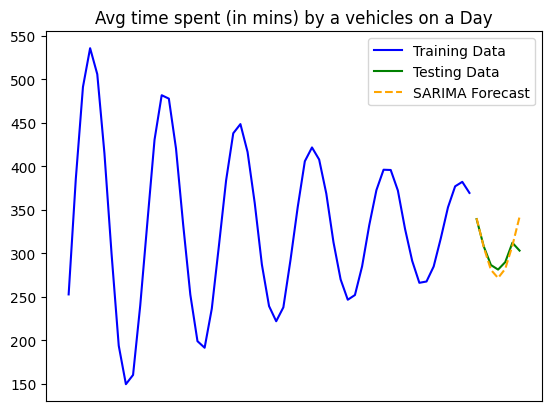


SARIMA Forecast

2024-11-08    340.220503
2024-11-09    306.875316
2024-11-10    280.873675
2024-11-11    271.494529
2024-11-12    282.025904
2024-11-13    308.664427
2024-11-14    341.882829
Freq: D, dtype: float64

SARIMA MASE: 0.209
SARIMA MAPE: 3.218



In [99]:
forecast(data)